## Notebook that takes dihadron ntuples and plots kinematics distributions also with MC

In [97]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time

import seaborn as sns

import root_pandas as rpd
from root_pandas import read_root

#mpl.rcParams['figure.figsize'] = 6.2,3.5
#mpl.rcParams['axes.labelsize'] = 17
#mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['lines.markersize'] = 6
#mpl.rcParams['legend.fontsize']= 13

In [98]:
df = {}
for target in ['Pb','Fe','C']:
    df[target]= read_root('Pairs_%s.root'%target, target)
    df['%s_mix'%target] = read_root('Pairs_%s.root'%target, '%s_mix'%target)
    df['D_%s'%target]= read_root('Pairs_%s.root'%target, 'D_%s'%target)
    df['D_%s_mix'%target] = read_root('Pairs_%s.root'%target, 'D_%s_mix'%target)

df_trigger = {}

for target in ['Pb','Fe','C']:
    df_trigger['%s_trigger'%target] = read_root('Pairs_%s.root'%target, '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = read_root('Pairs_%s.root'%target, 'D_%s_trigger'%target)
    
df['D'] = pd.concat([df['D_Pb'],df['D_Fe'],df['D_C']]) #simply combine the deuterium results for all targets
df['D_mix'] = pd.concat([df['D_Pb_mix'],df['D_Fe_mix'],df['D_C_mix']]) #simply combine the deuterium results for all targets
df_trigger['D_trigger'] = pd.concat([df_trigger['D_Pb_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_C_trigger']]) #simply combine the deuterium results for all targets



In [99]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe
def applyCuts(fullDataframe,name='default',isMC=False): 
    dataframe = fullDataframe
    print '/////////////////////////////////////'
    print 'Entries before cut ', dataframe.shape[0]
    dataframe.eval('inelasticity = Nu/5.014', inplace=True)
    dataframe.eval('E = z*Nu', inplace=True)
    dataframe.eval('z_tot = z+z_asso', inplace=True)

    dataframe.eval('E_asso = z_asso*Nu', inplace=True)
    dataframe.eval('P = sqrt(E*E-0.140*0.140)', inplace=True)
    dataframe.eval('P_asso = sqrt(E_asso*E_asso-0.140*0.140)', inplace=True)

    #event-level cuts    
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    dataframe = applyCut(dataframe, 'W>2.0', 'W>2.0 :')
    dataframe = applyCut(dataframe, 'inelasticity < 0.85','inelasticity < 0.85')

    #hadron level cuts
    dataframe = applyCut(dataframe, 'z>0.5 and z<1.0', '0.5<z<1.0 :')
    dataframe = applyCut(dataframe, 'z_tot<0.8', 'z_tot<0.8 :')

    dataframe = applyCut(dataframe, 'P <2.5 ', 'P<2.5 ')
    dataframe = applyCut(dataframe, 'P_asso <2.5 ', 'P_asso<2.5 ')
    print '/////////////////////////////////////'

    
    return dataframe

def printMeans(dataframe):   
    for variable in ['Q2','Xb','Nu','z','z_asso','P','P_asso']:
        print variable
        print 'Average ' + variable , np.mean(dataframe[variable]) , ' min--max ' , np.min(dataframe[variable]), np.max(dataframe[variable])
        print dataframe[variable].quantile([0.25,0.5,0.75])
  

    print 'Pairs with Leading pi+', dataframe.query('pid==211').shape[0]
    print 'Pairs with Leading pi-', dataframe.query('pid==-211').shape[0]
    print 'Pairs with Sub-Leading pi+', dataframe.query('pid_asso==211').shape[0]
    print 'Pairs with Sub-Leading pi-', dataframe.query('pid_asso==-211').shape[0]
    print 'pi+ pi+ pairs',dataframe.query('pid==211 and pid_asso==211').shape[0]
    print 'pi- pi- pairs',dataframe.query('pid==-211 and pid_asso==-211').shape[0]
    print 'pi+ pi- pairs',dataframe.query('pid==211 and pid_asso==-211').shape[0]
    print 'pi- pi+ pairs',dataframe.query('pid==-211 and pid_asso==211').shape[0]
    
    #print 'Pairs with Leading pi-', dataframe['pid'].count(-211)
    #print 'Pairs with Sub-Leading pi+', dataframe['pid_asso'].count(211)
    #print 'Pairs with Sub-Leading pi-', dataframe['pid_asso'].count(-211)

In [ ]:
#apply cuts

In [100]:
for key in ['Pb','C','Fe','D']:
    print key
    df[key] = applyCuts(df[key])
    #printMeans(df[key])
    print key
    print '--------------'

Pb
/////////////////////////////////////
Entries before cut  470634
Q2>1.0 : 470634  (100.00  %)
W>2.0 : 470630  (100.00  %)
inelasticity < 0.85 420694  (89.39  %)
0.4<z<1.0 : 10189  (2.42  %)
z_tot<0.8 : 7080  (69.49  %)
P<2.5  6759  (95.47  %)
P_asso<2.5  6759  (100.00  %)
/////////////////////////////////////
Pb
--------------
C
/////////////////////////////////////
Entries before cut  322742
Q2>1.0 : 322742  (100.00  %)
W>2.0 : 322738  (100.00  %)
inelasticity < 0.85 292226  (90.55  %)
0.4<z<1.0 : 9350  (3.20  %)
z_tot<0.8 : 6350  (67.91  %)
P<2.5  6047  (95.23  %)
P_asso<2.5  6047  (100.00  %)
/////////////////////////////////////
C
--------------
Fe
/////////////////////////////////////
Entries before cut  201828
Q2>1.0 : 201828  (100.00  %)
W>2.0 : 201822  (100.00  %)
inelasticity < 0.85 181760  (90.06  %)
0.4<z<1.0 : 4714  (2.59  %)
z_tot<0.8 : 3247  (68.88  %)
P<2.5  3082  (94.92  %)
P_asso<2.5  3082  (100.00  %)
/////////////////////////////////////
Fe
--------------
D
//////

In [101]:
for key in ['Pb_mix','C_mix','Fe_mix','D_mix']:
    print key
    df[key] = applyCuts(df[key])
    printMeans(df[key])
    print key
    print '--------------'

Pb_mix
/////////////////////////////////////
Entries before cut  143058
Q2>1.0 : 143058  (100.00  %)
W>2.0 : 143044  (99.99  %)
inelasticity < 0.85 135967  (95.05  %)
0.4<z<1.0 : 75129  (55.26  %)
z_tot<0.8 : 37418  (49.81  %)
P<2.5  35835  (95.77  %)
P_asso<2.5  35744  (99.75  %)
/////////////////////////////////////
Q2
Average Q2 1.6225850033001006  min--max  1.0000399351119995 3.8361382484436035
0.25    1.242051
0.50    1.492982
0.75    1.878456
Name: Q2, dtype: float64
Xb
Average Xb 0.2584409347502723  min--max  0.1256694495677948 0.5340185165405273
0.25    0.201553
0.50    0.247962
0.75    0.303286
Name: Xb, dtype: float64
Nu
Average Nu 3.372098407545523  min--max  2.3313071727752686 4.26177978515625
0.25    3.017699
0.50    3.378229
0.75    3.730283
Name: Nu, dtype: float64
z
Average z 0.5690220086081912  min--max  0.5000026213707669 0.7501388496828326
0.25    0.526406
0.50    0.558603
0.75    0.602121
Name: z, dtype: float64
z_asso
Average z_asso 0.12747864159274222  min--max  0

In [30]:
print df['C'].keys()

Index([u'Nu', u'Q2', u'Xb', u'dipion_pt', u'dphi', u'dy', u'mass',
       u'missing_mass', u'phi_pq', u'phi_pq_asso', u'pid', u'pid_asso', u't',
       u'u', u'xf', u'xf_asso', u'y', u'y_asso', u'y_star', u'z', u'z_asso',
       u'inelasticity', u'E', u'E_asso', u'P', u'P_asso', u'z_tot'],
      dtype='object')


## Event Variables

In [12]:
def plotEventVariables(df):
    fig = plt.figure( figsize=(20, 10))
    plt.subplot(2,3,1)
    plt.hist(df['Nu'], bins=25,range =(2,5), histtype='step', normed=True,label='Data')
    plt.legend()
    plt.xlabel("Nu [GeV]", fontsize=20)

    plt.subplot(2,3,2)
    plt.hist(df['Q2'], bins=25,range =(1,5), histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['Q2'], bins=25,range = (1,5),  normed = True,alpha=0.2,label='MC')
    plt.xlabel("$Q^{2} [GeV^{2}]$", fontsize=20)

    #plt.subplot(2,3,3)
    #plt.hist(df['W'], bins=25,range =(1,3), histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['W'], bins=25,range = (1,3), normed = True,alpha=0.2,label='MC')
    #plt.xlabel("$W$ [GeV]", fontsize=20)

    plt.subplot(2,3,4)
    plt.hist(df['Xb'], bins=25,range =(0,1), histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['Xb'], bins=25,range = (0,1),  normed = True,alpha=0.2,label='MC')
    plt.xlabel("$x$", fontsize=20)
    
    plt.subplot(2,3,5)
    plt.hist(df['inelasticity'], bins=25,range =(0,1), histtype='step', normed=True,label='Data')
    plt.legend()
    plt.xlabel("inelasticity", fontsize=20)
    plt.axvline(x=.850,color='red',linestyle='--')


    #plt.subplot(2,3,5)
    #plt.hist(df['SectorEl'], bins = 12, range = (-0.5,5.5),histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['SectorEl'], bins = 12, range=(-0.5,5.5), normed = True,alpha=0.2,label='MC')
    #plt.xlabel('Sector El')

    #plt.subplot(2,3,6)
    #plt.hist(df['deltaZ'], bins = 100, range=(-50,50), histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['deltaZ'], bins = 100, range=(-50,50), normed = True,alpha=0.2,label='MC')
    #plt.xlabel('Delta z')
    #plt.show()
    
    return

## Hadron Variables

In [78]:
def plotHadronVariables(df):
    fig = plt.figure( figsize=(16, 16))
    plt.subplot(3,4,1)
    plt.hist(df['xf'], bins=25,range=(-1,1), histtype='step', normed=True,label='xf_1')
    plt.hist(df['xf_asso'], bins=25,range=(-1,1), histtype='step', normed=True,label='xf_2')
    plt.legend(loc='best', frameon=False)
    plt.xlabel("$X_{\mathrm{f}}$", fontsize=14)

    plt.subplot(3,4,2)
    plt.hist(df['z'], bins=25,range =(0,1), histtype='step', normed=True,label='z1')
    plt.hist(df['z_asso'], bins=25,range =(0,1), histtype='step', normed=True,label='z2')
    plt.hist(df['z_tot'], bins=25,range =(0,1), histtype='step', normed=True,label='z1+z2')
    plt.legend()
    plt.xlabel("$z_{\mathrm{h}}$", fontsize=14)
    
    plt.subplot(3,4,3)
    plt.hist(df['y'], range=(-2.5,2.5), bins = 50,histtype='step', normed=True,label='y1')
    plt.hist(df['y_asso'], range=(-2.5,2.5), bins = 50,histtype='step', normed=True,label='y2')
    plt.xlabel("rapidity", fontsize=14)
    plt.legend()
    
    plt.subplot(3,4,4)
    plt.hist(df['phi_pq'], bins=25, histtype='step', normed=True,label='phi1')
    plt.hist(df['phi_pq_asso'], bins=25, histtype='step', normed=True,label='phi2')
    plt.xlabel("$\phi_{pq}$ [\circ]", fontsize=14)
    plt.legend()
    
    plt.subplot(3,4,5)
    plt.hist(df['mass'], bins=50, histtype='step', range=(0,2.0),normed=True)
    plt.axvline(x=0.770,linestyle='--',color='black',alpha=0.4)

    plt.xlabel("mass [GeV]", fontsize=14)

    plt.subplot(3,4,6)
    plt.hist(df['missing_mass'], bins=50, histtype='step', range=(0,2.0),normed=True)
    plt.axvline(x=0.938,linestyle='--',color='black',alpha=0.4)
    plt.xlabel("missing mass [GeV]", fontsize=14)
    
    plt.subplot(3,4,7)
    plt.hist(df['dy'], bins=50, histtype='step', range=(-3.5,3.5),normed=True)
    plt.xlabel("delta-rapidity", fontsize=14)
    
    
    plt.subplot(3,4,8)
    plt.hist(df['dphi'], bins=20, histtype='step',normed=True)
    plt.xlabel("dphi", fontsize=14)
    
    
    plt.subplot(3,4,9)
    plt.hist(df['dipion_pt'], bins=50, histtype='step',range=(0.0,5.0),normed=True, label='dipion pt')
    plt.hist(df['t'], bins=50, histtype='step',range=(0.0,5.0),normed=True,label='t')
    plt.legend()
    plt.xlabel("dipion_pt", fontsize=14)

    plt.subplot(3,4,10)
    plt.hist(df['P'], bins=50,range =(0,3.0), histtype='step', normed=True,label='P1')
    plt.hist(df['P_asso'], bins=50,range =(0,3.0), histtype='step', normed=True,label='P2')
    plt.xlabel("$P$ GeV" , fontsize=14)
    plt.legend()
    
    plt.subplot(3,4,11)
    plt.hist(df['E'], bins=50,range =(0,3.0), histtype='step', normed=True,label='E1')
    plt.hist(df['E_asso'], bins=50,range =(0,3.0), histtype='step', normed=True,label='E2')
    plt.xlabel("$E$ GeV", fontsize=14)
    plt.legend()

    


    plt.show()
    return 

## Profile distributions to see correlation with kinematic variables with z2

#### This is accomplished with sns.regplot (seaborn package needed). It plots the average of a quantity in bins o the other quantities. This is more useful than a 2D distribution

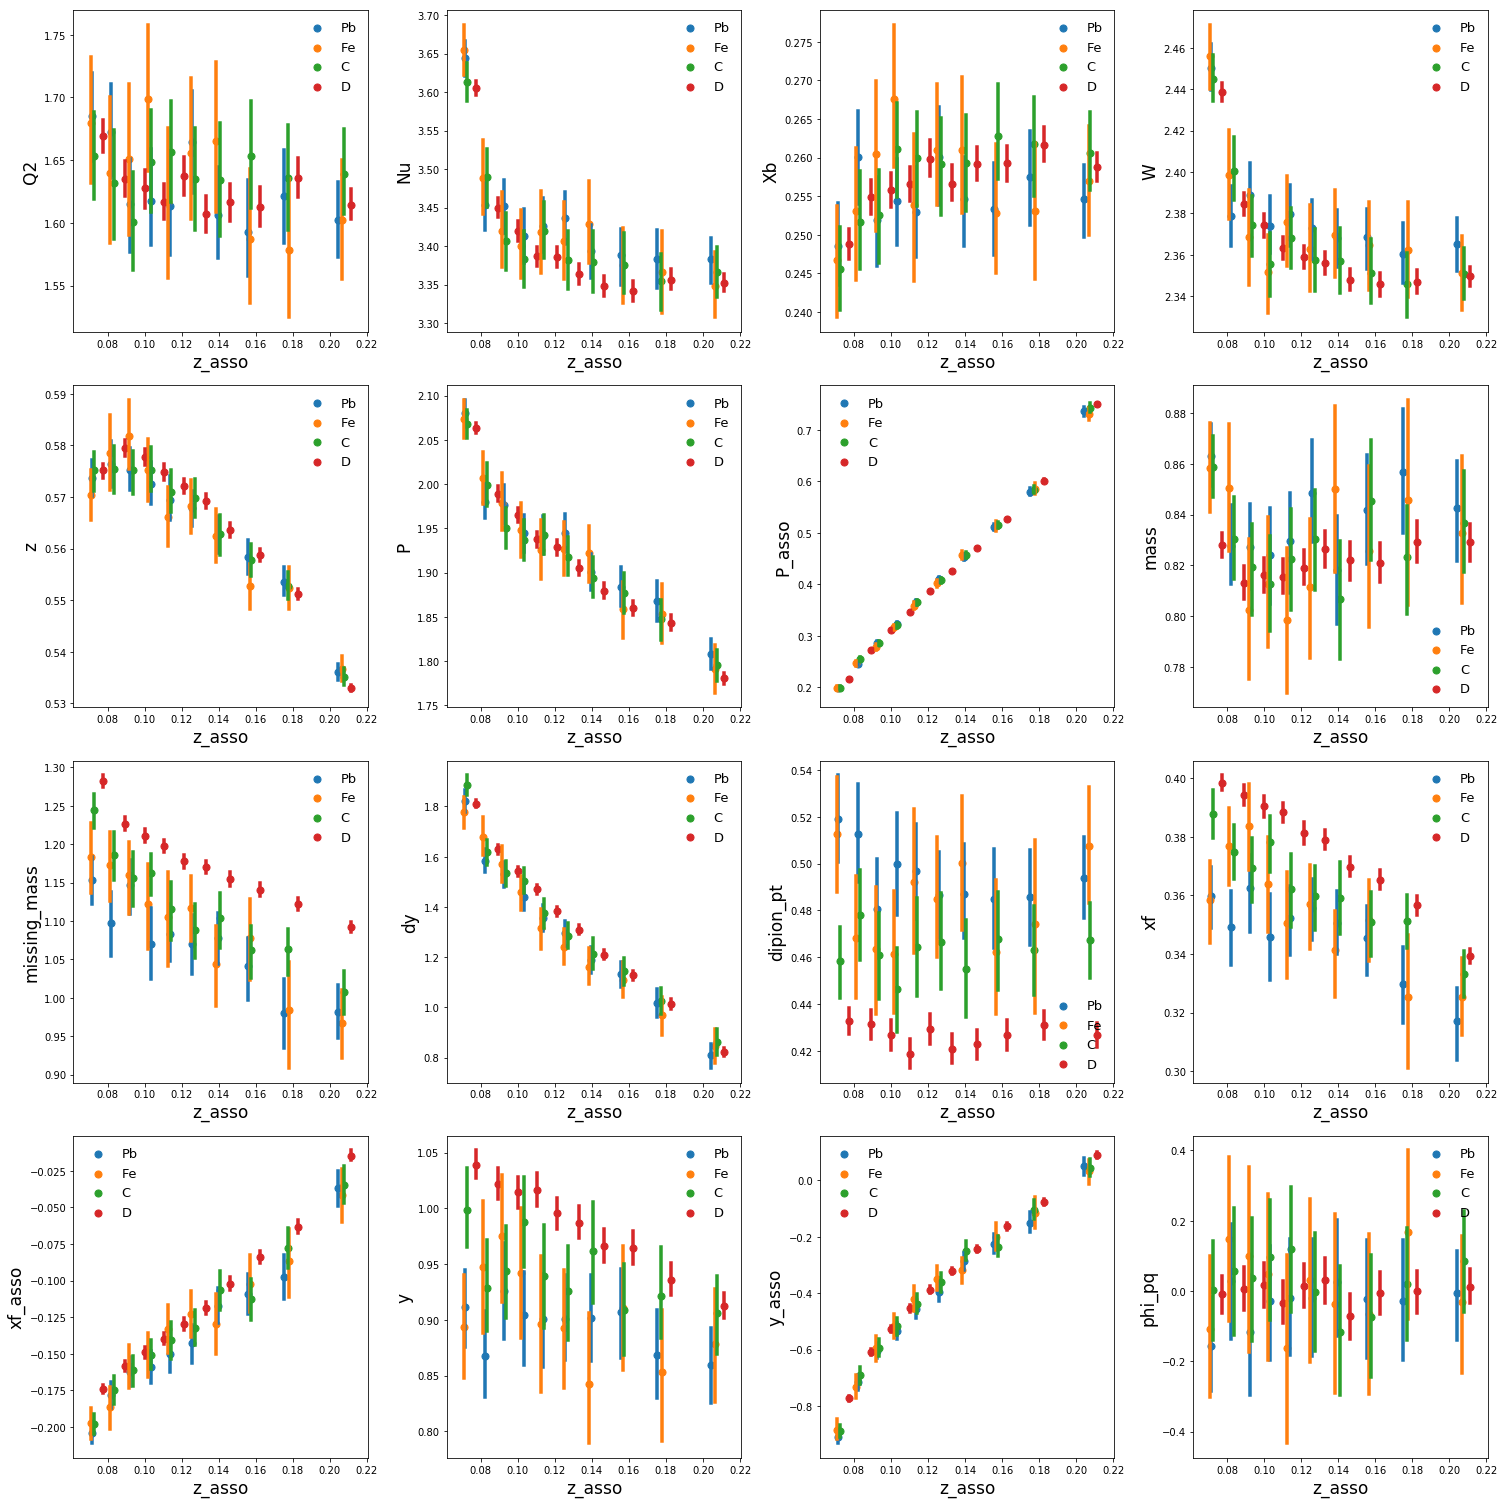

In [120]:
fig = plt.figure( figsize=(21, 21))

for ivar,variable in enumerate(['Q2','Nu','Xb','W','z','P','P_asso','mass','missing_mass','dy','dipion_pt','xf','xf_asso','y','y_asso','phi_pq']):
    plt.subplot(4,4,ivar+1)
    for i, target in enumerate(['Pb','Fe','C','D']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=10,fit_reg=None,label=target)
    plt.legend(loc='best',frameon=False)
    
plt.tight_layout()
plt.savefig('ProfilePlots.png')

## plot for mixed events. In this case, key correlation should go away


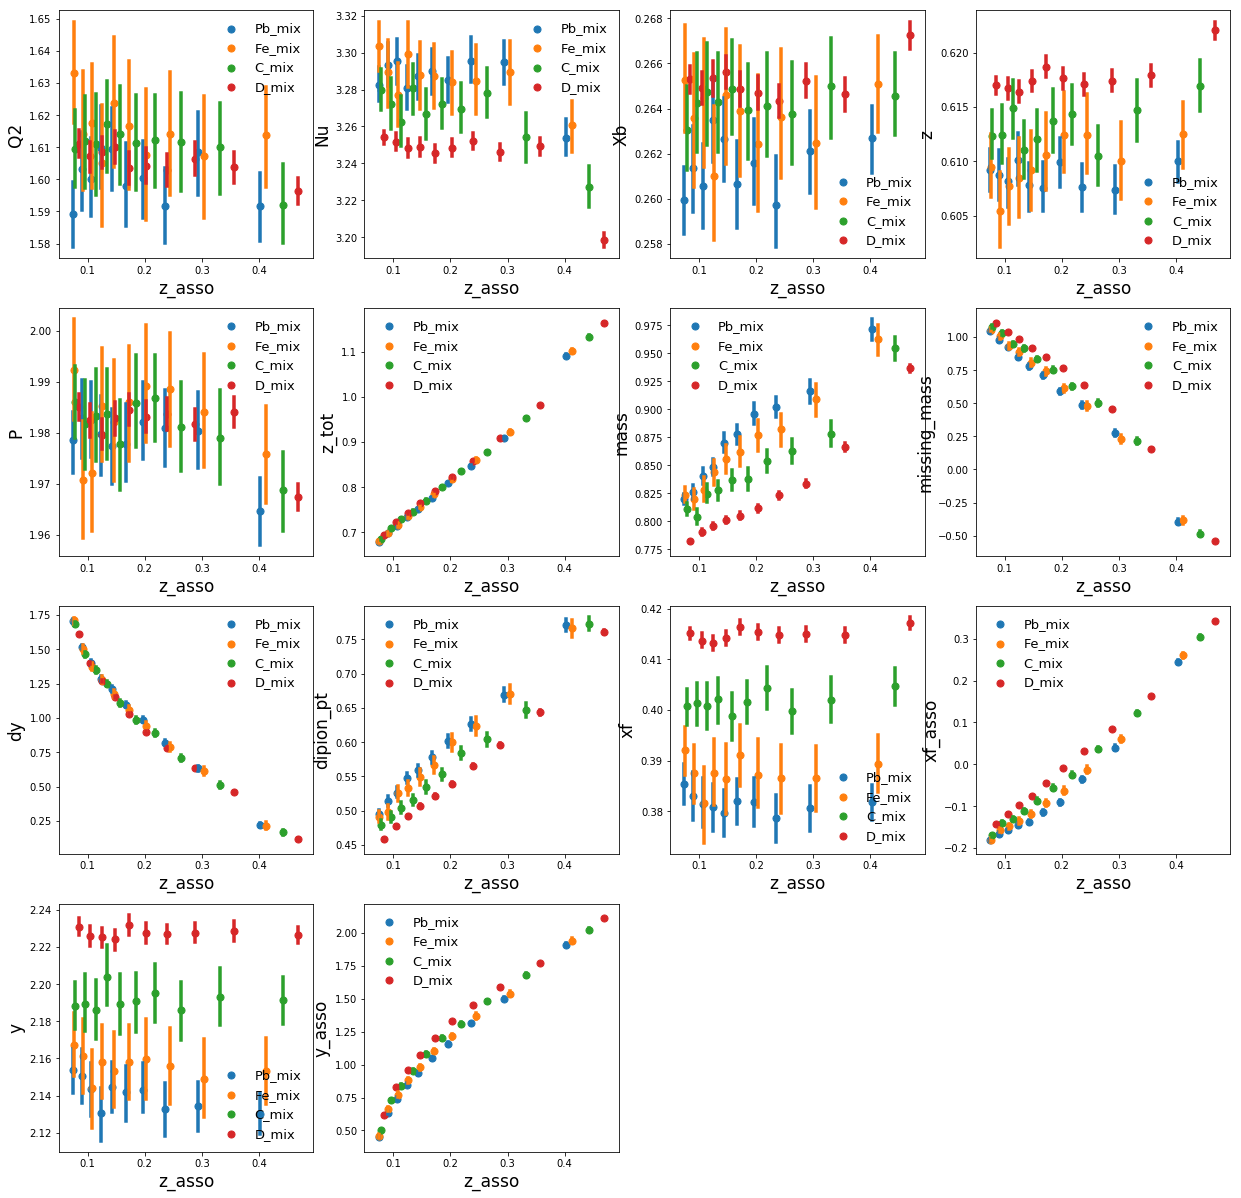

In [44]:
fig = plt.figure( figsize=(21, 21))

for ivar,variable in enumerate(['Q2','Nu','Xb','z','P','z_tot','mass','missing_mass','dy','dipion_pt','xf','xf_asso','y','y_asso']):
    plt.subplot(4,4,ivar+1)
    for i, target in enumerate(['Pb_mix','Fe_mix','C_mix','D_mix']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=10,fit_reg=None,label=target)
    plt.legend(loc='best',frameon=False)

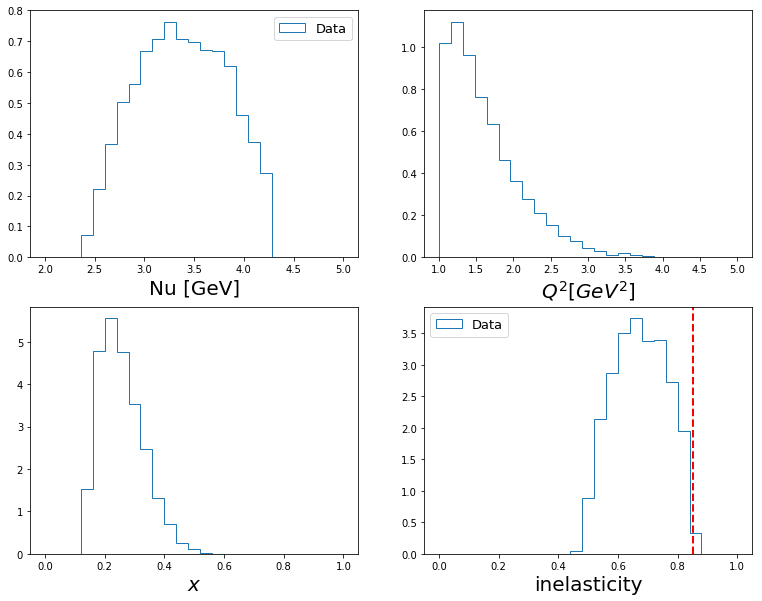

In [37]:
plotEventVariables(df['Pb'])


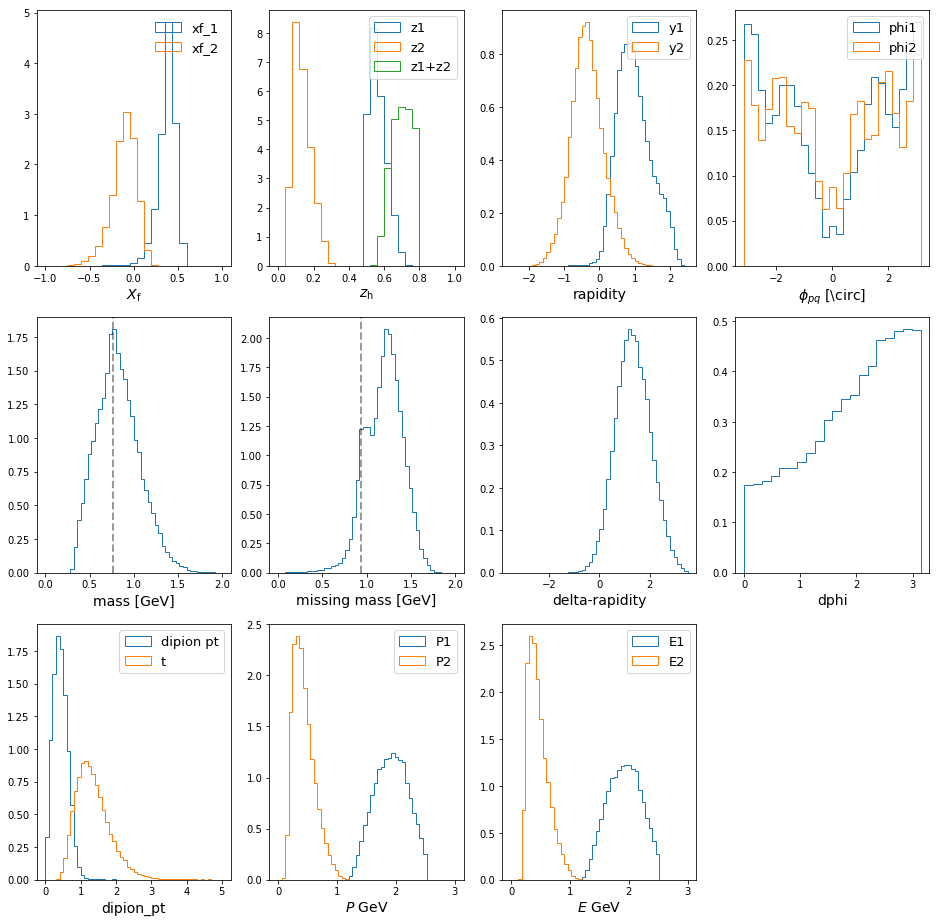

In [115]:
plotHadronVariables(df['D'])

/usr/local/lib/python2.7/dist-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python2.7/dist-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


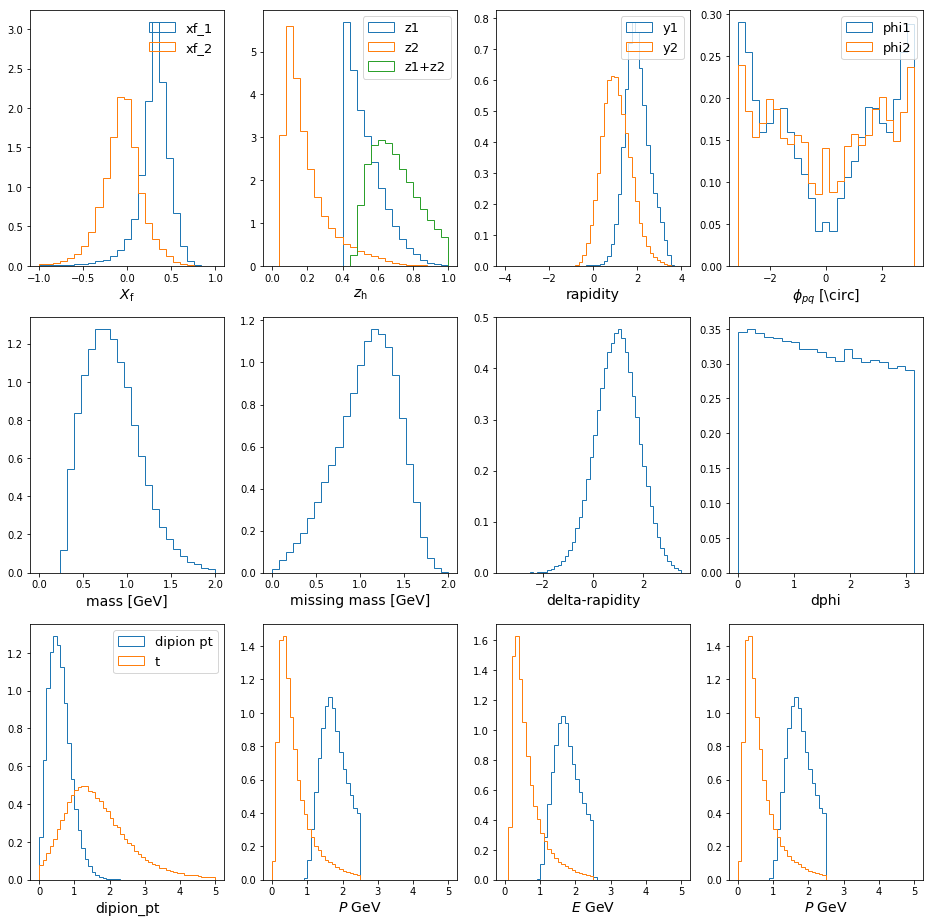

In [62]:
plotHadronVariables(df['Pb_mix'])

## invariant mass distribution

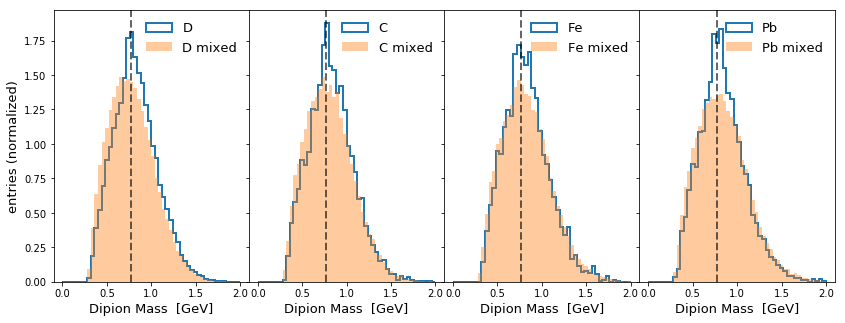

In [102]:
fig, axs = plt.subplots(1, 4,sharex=True, sharey=True,figsize=(14,5), gridspec_kw={'wspace':0})

for i, target in enumerate(['D','C','Fe','Pb']):
    axs[i].hist(df[target]['mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='%s'%target,linewidth=2.0)
    axs[i].hist(df['%s_mix'%target]['mass'], bins=50, range=(0,2.0),normed=True,alpha=0.4,label='%s mixed'%target)
    axs[i].axvline(x=0.770,linestyle='--',color='black',alpha=0.6)
    axs[i].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
    axs[i].legend(loc='best',frameon=False)

axs[0].yaxis.set_label_text("entries (normalized)", fontsize=13)




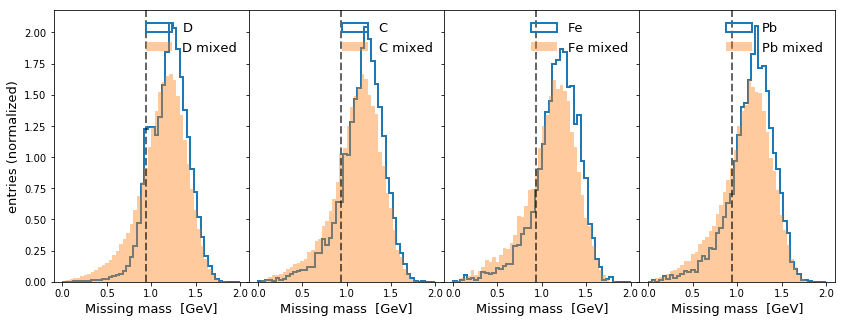

In [103]:
fig, axs = plt.subplots(1, 4,sharex=True, sharey=True,figsize=(14,5), gridspec_kw={'wspace':0})

for i, target in enumerate(['D','C','Fe','Pb']):
    axs[i].hist(df[target]['missing_mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='%s'%target,linewidth=2.0)
    axs[i].hist(df['%s_mix'%target]['missing_mass'], bins=50, range=(0,2.0),normed=True,alpha=0.4,label='%s mixed'%target)
    axs[i].axvline(x=0.938,linestyle='--',color='black',alpha=0.6)
    axs[i].xaxis.set_label_text("Missing mass  [GeV]", fontsize=13)
    axs[i].legend(loc='best',frameon=False)

axs[0].yaxis.set_label_text("entries (normalized)", fontsize=13)



## z_asso

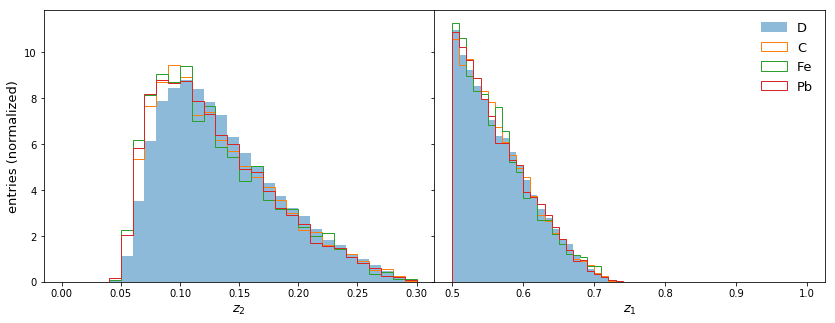

In [113]:
fig, axs = plt.subplots(1, 2,sharey=True,figsize=(14,5), gridspec_kw={'wspace':0})

axs[0].hist(df['D']['z_asso'], bins=30,range =(0,0.3), normed=True,label='D',alpha=0.5)

for i, target in enumerate(['C','Fe','Pb']):
    axs[0].hist(df[target]['z_asso'], bins=30,range =(0,0.3), histtype='step', normed=True,label=[target])
    
axs[1].hist(df['D']['z'], bins=50,range =(0.5,1.0), normed=True,label='D',alpha=0.5)
for i, target in enumerate(['C','Fe','Pb']):
    axs[1].hist(df[target]['z'], bins=50,range =(0.5,1.0), histtype='step', normed=True,label=[target]) 
 

axs[0].xaxis.set_label_text("$z_{2}$", fontsize=13)
axs[1].xaxis.set_label_text("$z_{1}$", fontsize=13)
axs[0].yaxis.set_label_text("entries (normalized)", fontsize=13)

plt.legend(loc='best',frameon=False)
plt.show()

In [ ]:
fig = plt.figure( figsize=(12, 12))
plt.subplot(3,3,1)
plt.hexbin(data['Pt'],data['Zh'],bins='log',cmap='viridis')
plt.xlabel("$p_{\mathrm{T}}$ [GeV]", fontsize=14)
plt.ylabel("$z_{\mathrm{h}}$ ", fontsize=14)

plt.subplot(3,3,2)
plt.hexbin(data['Q2'],data['Xb'],gridsize=50, bins='log',cmap='viridis')
plt.xlabel("$Q^{2} [GeV^{2}]$", fontsize=14)
plt.ylabel("$X_{b}$", fontsize=14)

plt.subplot(3,3,3)
plt.hexbin(data['Q2'],data['Nu'],gridsize=50,bins='log',cmap='viridis')
plt.xlabel("$Q^{2} [GeV^{2}]$", fontsize=14)
plt.ylabel("$Nu$ ", fontsize=14)

plt.subplot(3,3,4)
plt.hexbin(data.query('Zh<1.0')['PhiPQ'],data.query('Zh<1.0')['Zh'],bins='log',cmap='viridis')
plt.xlabel("$\phi_{pq}$ [\circ]", fontsize=14)
plt.ylabel("$z_{\mathrm{h}}$ ", fontsize=14)

plt.subplot(3,3,5)
plt.hexbin(data.query('Pt<1.5')['PhiPQ'],data.query('Pt<1.5')['Pt'],bins='log',cmap='viridis')
plt.xlabel("$\phi_{pq}$ [\circ]", fontsize=20)
plt.ylabel("$p_{\mathrm{T}}$ [GeV]", fontsize=20)

plt.subplot(3,3,6)
plt.hexbin(data.query('Zh<1.0 and Xf>-1.0')['Xf'],data.query('Zh<1.0 and Xf>-1.0')['Zh'],bins='log',cmap='viridis')
plt.xlabel("X_{F}", fontsize=14)
plt.ylabel("$z_{\mathrm{h}}$ ", fontsize=14)

plt.subplot(3,3,7)
plt.hexbin(data.query('Zh<1.0 and y>-4')['y'],data.query('Zh<1.0 and y>-4')['Zh'],bins='log',cmap='viridis')
plt.xlabel("Rapidity", fontsize=14)
plt.ylabel("$z_{\mathrm{h}}$ ", fontsize=14)

plt.subplot(3,3,8)
plt.hexbin(data.query('abs(Xf)<1.0 and y>-4')['y'],data.query('abs(Xf)<1.0 and y>-4')['Xf'],bins='log',cmap='viridis')
plt.xlabel("Rapidity", fontsize=14)
plt.ylabel("X_{F}", fontsize=14)


plt.show()